In [ ]:
# === Baseline diarization: ECAPA embeddings + agglomerative clustering (oracle K) ===
# --- Mount Drive
from google.colab import drive
drive.mount('/content/drive')

!pip -q install speechbrain soundfile librosa scikit-learn

import os, json
import numpy as np
import soundfile as sf
import librosa
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering
from speechbrain.pretrained import EncoderClassifier
import torch

# ---------- Paths ----------
BASE = "/content/drive/MyDrive/problem_statement_6"
SCENARIO_DIR = f"{BASE}/sessions_smooth"   # change to sessions_balanced / high_overlap / codeswitch as needed
OUT_DIR = f"{BASE}/outputs/sd/sessions_smooth"
os.makedirs(OUT_DIR, exist_ok=True)

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 864.1/864.1 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 754.1/754.1 kB 33.6 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/speechbrain/utils/torch_audio_backend.py:57: UserWarning: torchaudio._backend.list_audio_backends has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  available_backends = torchaudio.list_audio_backends()
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _speechbrain_save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _speechbrain_load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoi

In [ ]:
import os, json
import numpy as np
import soundfile as sf
import librosa
from tqdm import tqdm
import torch
from sklearn.cluster import AgglomerativeClustering
from speechbrain.pretrained import EncoderClassifier


class Diarizer:
    def __init__(self, base_dir, scenario, out_subdir="outputs/sd",
                 win_sec=1.5, hop_sec=0.75, min_region_sec=0.5, batch_size=16):
        """
        base_dir: root of problem_statement_6
        scenario: e.g. 'sessions_smooth'
        """
        self.base_dir = base_dir
        self.scenario = scenario
        self.in_dir = os.path.join(base_dir, scenario)
        self.out_dir = os.path.join(base_dir, out_subdir, scenario)
        os.makedirs(self.out_dir, exist_ok=True)

        self.SR = 16000
        self.WIN_SEC = win_sec
        self.HOP_SEC = hop_sec
        self.MIN_REGION_SEC = min_region_sec
        self.BATCH_SIZE = batch_size

        # GPU setup
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Pretrained embedder
        self.encoder = EncoderClassifier.from_hparams(
            source="speechbrain/spkrec-ecapa-voxceleb",
            run_opts={"device": str(self.device)}
        )

    # ----------------- Core Helpers -----------------

    def frame_audio(self, x, sr):
        win = int(round(self.WIN_SEC * sr))
        hop = int(round(self.HOP_SEC * sr))
        frames, starts = [], []
        for s in range(0, len(x) - win + 1, hop):
            e = s + win
            frames.append(x[s:e])
            starts.append(s / sr)
        # tail frame if leftover is long enough
        if len(x) % hop != 0:
            s = len(x) - win
            if s > 0 and (len(x) - s) / sr >= 0.5 * self.WIN_SEC:
                frames.append(x[s:])
                starts.append(max(0, s) / sr)
        return frames, np.array(starts, dtype=np.float32)

    def embed_frames(self, frames):
        """Batch pad frames and compute ECAPA embeddings on GPU."""
        if not frames:
            return np.zeros((0, 192), dtype=np.float32)

        embs_list = []
        for i in range(0, len(frames), self.BATCH_SIZE):
            chunk = frames[i:i+self.BATCH_SIZE]
            maxlen = max(len(f) for f in chunk)
            pad_np = np.stack(
                [np.pad(f.astype(np.float32), (0, maxlen - len(f))) for f in chunk],
                axis=0
            )
            wavs = torch.from_numpy(pad_np).to(self.device)
            with torch.no_grad():
                emb = self.encoder.encode_batch(wavs)  # [B, 1, D]
            embs_list.append(emb.squeeze(1).cpu().numpy())
        return np.vstack(embs_list)

    def cluster_embeddings(self, embs, n_spk):
        if len(embs) == 0:
            return np.array([], dtype=int)
        clust = AgglomerativeClustering(
            n_clusters=n_spk, metric='cosine', linkage='average'
        )
        return clust.fit_predict(embs)

    def labels_to_regions(self, starts, labels):
        """Merge consecutive frames into regions per speaker label."""
        if len(labels) == 0:
            return []
        regions = []
        cur_lab, cur_start, cur_end = labels[0], float(starts[0]), float(starts[0]) + self.WIN_SEC
        for i in range(1, len(labels)):
            s, e = float(starts[i]), float(starts[i]) + self.WIN_SEC
            if labels[i] == cur_lab and abs(s - cur_end) <= 1e-6:
                cur_end = e
            else:
                if cur_end - cur_start >= self.MIN_REGION_SEC:
                    regions.append((cur_start, cur_end, int(cur_lab)))
                cur_lab, cur_start, cur_end = labels[i], s, e
        if cur_end - cur_start >= self.MIN_REGION_SEC:
            regions.append((cur_start, cur_end, int(cur_lab)))
        return regions

    def map_clusters(self, labels):
        uniq = np.unique(labels)
        mapping = {lab: f"spk{idx+1:02d}" for idx, lab in enumerate(sorted(uniq))}
        return np.vectorize(mapping.get)(labels), mapping

    def read_oracle_n_speakers(self, jsonl_path):
        spk = set()
        with open(jsonl_path, "r", encoding="utf-8") as f:
            for line in f:
                if not line.strip():
                    continue
                rec = json.loads(line)
                if rec.get("speaker"):
                    spk.add(rec["speaker"])
        return max(1, len(spk))

    # ----------------- Main Run -----------------

    def diarize_all(self):
        jsonl_files = sorted([f for f in os.listdir(self.in_dir) if f.endswith(".jsonl")])
        assert jsonl_files, f"No .jsonl found in {self.in_dir}"

        for jname in tqdm(jsonl_files, desc=f"Diarizing {self.scenario}"):
            base = jname[:-6]
            wav_path = os.path.join(self.in_dir, base + ".wav")
            jpath = os.path.join(self.in_dir, jname)
            out_csv = os.path.join(self.out_dir, f"SD_{base}.csv")

            if not os.path.exists(wav_path):
                print(f" ! missing wav for {jname}, skipping")
                continue

            x, sr = sf.read(wav_path, always_2d=False)
            if sr != self.SR:
                x = librosa.resample(x.astype(np.float32), orig_sr=sr, target_sr=self.SR)
                sr = self.SR
            if x.ndim == 2:
                x = x.mean(axis=1)

            frames, starts = self.frame_audio(x, sr)
            embs = self.embed_frames(frames)
            K = self.read_oracle_n_speakers(jpath)
            clabels = self.cluster_embeddings(embs, K)
            regions = self.labels_to_regions(starts, clabels)
            _, mapping = self.map_clusters(clabels if len(clabels) else np.array([0]))

            with open(out_csv, "w", encoding="utf-8") as f:
                f.write("start_ts,end_ts,speaker\n")
                for (s, e, lab) in regions:
                    f.write(f"{s:.3f},{e:.3f},{mapping.get(lab, f'spk{lab+1:02d}')}\n")

            print(f"Wrote {os.path.basename(out_csv)} (regions: {len(regions)}, K={K})")

        print(f"\n✅ Done. CSVs in {self.out_dir}")

In [ ]:
BASE = "/content/drive/MyDrive/problem_statement_6"

# Example: run on sessions_smooth
dia = Diarizer(BASE, scenario="sessions_smooth")
dia.diarize_all()

# Switch scenario easily:
# dia = Diarizer(BASE, scenario="sessions_balanced")
# dia.diarize_all()

INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Fetching files for pretraining (no collection directory set)
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /root/.cache/hugg

Wrote SD_session_001.csv (regions: 804, K=4)


Diarizing sessions_smooth:  10%|█         | 2/20 [00:06<00:57,  3.17s/it]

Wrote SD_session_002.csv (regions: 801, K=3)


Diarizing sessions_smooth:  15%|█▌        | 3/20 [00:09<00:54,  3.19s/it]

Wrote SD_session_003.csv (regions: 799, K=3)


Diarizing sessions_smooth:  20%|██        | 4/20 [00:12<00:51,  3.22s/it]

Wrote SD_session_004.csv (regions: 804, K=4)


Diarizing sessions_smooth:  25%|██▌       | 5/20 [00:16<00:48,  3.22s/it]

Wrote SD_session_005.csv (regions: 808, K=3)


Diarizing sessions_smooth:  30%|███       | 6/20 [00:19<00:44,  3.15s/it]

Wrote SD_session_006.csv (regions: 799, K=3)


Diarizing sessions_smooth:  35%|███▌      | 7/20 [00:22<00:41,  3.21s/it]

Wrote SD_session_007.csv (regions: 807, K=4)


Diarizing sessions_smooth:  40%|████      | 8/20 [00:25<00:39,  3.25s/it]

Wrote SD_session_008.csv (regions: 806, K=4)


Diarizing sessions_smooth:  45%|████▌     | 9/20 [00:28<00:34,  3.14s/it]

Wrote SD_session_009.csv (regions: 800, K=4)


Diarizing sessions_smooth:  50%|█████     | 10/20 [00:32<00:32,  3.25s/it]

Wrote SD_session_010.csv (regions: 801, K=4)


Diarizing sessions_smooth:  55%|█████▌    | 11/20 [00:35<00:30,  3.37s/it]

Wrote SD_session_011.csv (regions: 805, K=4)


Diarizing sessions_smooth:  60%|██████    | 12/20 [00:38<00:26,  3.29s/it]

Wrote SD_session_012.csv (regions: 804, K=4)


Diarizing sessions_smooth:  65%|██████▌   | 13/20 [00:42<00:23,  3.29s/it]

Wrote SD_session_013.csv (regions: 802, K=3)


Diarizing sessions_smooth:  70%|███████   | 14/20 [00:47<00:22,  3.76s/it]

Wrote SD_session_014.csv (regions: 799, K=4)


Diarizing sessions_smooth:  75%|███████▌  | 15/20 [00:50<00:17,  3.58s/it]

Wrote SD_session_015.csv (regions: 799, K=3)


Diarizing sessions_smooth:  80%|████████  | 16/20 [00:54<00:15,  3.80s/it]

Wrote SD_session_016.csv (regions: 800, K=3)


Diarizing sessions_smooth:  85%|████████▌ | 17/20 [00:57<00:10,  3.57s/it]

Wrote SD_session_017.csv (regions: 803, K=3)


Diarizing sessions_smooth:  90%|█████████ | 18/20 [01:00<00:06,  3.34s/it]

Wrote SD_session_018.csv (regions: 804, K=3)


Diarizing sessions_smooth:  95%|█████████▌| 19/20 [01:03<00:03,  3.18s/it]

Wrote SD_session_019.csv (regions: 804, K=3)


Diarizing sessions_smooth: 100%|██████████| 20/20 [01:06<00:00,  3.31s/it]

Wrote SD_session_020.csv (regions: 802, K=4)

✅ Done. CSVs in /content/drive/MyDrive/problem_statement_6/outputs/sd/sessions_smooth


In [ ]:
import os, json
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment

class Evaluator:
    def __init__(self, scenario_dir, pred_dir, sr=16000, min_region_s=0.1):
        self.scenario_dir = scenario_dir
        self.pred_dir = pred_dir
        self.sr = sr
        self.min_region_s = min_region_s

    # ------------------- Loaders -------------------
    def load_gt(self, jsonl_path):
        """Load ground-truth regions from session .jsonl"""
        regions = []
        with open(jsonl_path, "r", encoding="utf-8") as f:
            for line in f:
                if not line.strip():
                    continue
                rec = json.loads(line)
                s, e = float(rec["start_ts"]), float(rec["end_ts"])
                if e - s < self.min_region_s:
                    continue
                spk = rec.get("speaker", "unk")
                regions.append((s, e, spk))
        return regions

    def load_pred(self, csv_path):
        """Load predicted diarization from CSV"""
        regions = []
        with open(csv_path, "r", encoding="utf-8") as f:
            next(f)  # skip header
            for line in f:
                s, e, spk = line.strip().split(",")
                s, e = float(s), float(e)
                if e - s < self.min_region_s:
                    continue
                regions.append((s, e, spk))
        return regions

    # ------------------- Scoring -------------------
    def score_session(self, gt_regions, pred_regions):
        """Compute DER-style metrics for one session"""
        # Collect unique speakers
        gt_spk = sorted(set(spk for _, _, spk in gt_regions))
        pr_spk = sorted(set(spk for _, _, spk in pred_regions))

        # Build confusion matrix: [GT, Pred] overlap time
        cm = np.zeros((len(gt_spk), len(pr_spk)))
        for gs, ge, g in gt_regions:
            for ps, pe, p in pred_regions:
                overlap = max(0.0, min(ge, pe) - max(gs, ps))
                if overlap > 0:
                    cm[gt_spk.index(g), pr_spk.index(p)] += overlap

        # Hungarian alignment: maximize overlap
        cost = -cm  # maximize overlap = minimize -overlap
        row_ind, col_ind = linear_sum_assignment(cost)
        mapping = {pr_spk[j]: gt_spk[i] for i, j in zip(row_ind, col_ind)}

        # Now accumulate errors
        total_gt = sum(e - s for s, e, _ in gt_regions)
        miss, fa, conf = 0.0, 0.0, 0.0

        for gs, ge, g in gt_regions:
            for ps, pe, p in pred_regions:
                overlap = max(0.0, min(ge, pe) - max(gs, ps))
                if overlap <= 0:
                    continue
                if mapping.get(p, None) == g:
                    continue  # correct
                else:
                    conf += overlap

        # Missed speech = GT not covered at all
        for gs, ge, g in gt_regions:
            dur = ge - gs
            covered = sum(max(0.0, min(ge, pe) - max(gs, ps))
                          for ps, pe, _ in pred_regions)
            miss += max(0.0, dur - covered)

        # False alarm = Predicted with no GT
        for ps, pe, p in pred_regions:
            dur = pe - ps
            covered = sum(max(0.0, min(pe, ge) - max(ps, gs))
                          for gs, ge, _ in gt_regions)
            fa += max(0.0, dur - covered)

        der = 100.0 * (miss + fa + conf) / total_gt if total_gt > 0 else 0.0
        return {"DER": der, "miss": miss, "fa": fa, "conf": conf, "total_gt": total_gt}

    def score_all(self):
        """Evaluate all sessions in scenario_dir vs pred_dir"""
        rows = []
        for fname in sorted(os.listdir(self.scenario_dir)):
            if not fname.endswith(".jsonl"):
                continue
            base = fname[:-6]
            jsonl_path = os.path.join(self.scenario_dir, fname)
            csv_path = os.path.join(self.pred_dir, f"SD_{base}.csv")
            if not os.path.exists(csv_path):
                print(f"! Missing pred for {base}, skipping")
                continue
            gt = self.load_gt(jsonl_path)
            pred = self.load_pred(csv_path)
            res = self.score_session(gt, pred)
            res["session"] = base
            rows.append(res)

        df = pd.DataFrame(rows)
        avg = df.mean(numeric_only=True).to_dict()
        avg["session"] = "AVERAGE"
        df = pd.concat([df, pd.DataFrame([avg])], ignore_index=True)
        return df


In [ ]:
BASE = "/content/drive/MyDrive/problem_statement_6"
scenario = f"{BASE}/sessions_smooth"
preds = f"{BASE}/outputs/sd/sessions_smooth"

evaluator = Evaluator(scenario, preds)
df = evaluator.score_all()
print(df)

           DER  miss         fa      conf   total_gt      session
0   152.300800   0.0   95.07700  767.6720  566.47700  session_001
1   126.734124   0.0  108.92400  595.9750  556.20300  session_002
2   140.501992   0.0  101.79400  687.1570  561.52300  session_003
3   159.726032   0.0   99.24500  815.0300  572.40200  session_004
4   140.365830   0.0   91.15400  713.5240  573.27200  session_005
5   139.406575   0.0  108.88400  669.4020  558.28500  session_006
6   154.449848   0.0  111.65000  746.1660  555.40100  session_007
7   148.553461   0.0   99.22700  738.4110  563.86300  session_008
8   156.751194   0.0  106.79300  756.0220  550.43600  session_009
9   158.798877   0.0  104.41200  793.6020  565.50400  session_010
10  146.026406   0.0   92.81600  732.7180  565.33200  session_011
11  151.578820   0.0   88.98600  776.2350  570.80600  session_012
12  143.354855   0.0  101.76700  703.7640  561.91400  session_013
13  160.632784   0.0  108.59300  795.4210  562.78300  session_014
14  129.89

In [ ]:
import os, json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class TimelineVisualizer:
    def __init__(self, base_dir, out_dir):
        """
        base_dir: path to scenario sessions (with .jsonl + .wav)
        out_dir:  path where SD CSV predictions are stored
        """
        self.base_dir = base_dir
        self.out_dir = out_dir

    def _load_groundtruth(self, session_id):
        """Load ground-truth diarization from .jsonl"""
        jpath = os.path.join(self.base_dir, f"{session_id}.jsonl")
        gt_segments = []
        with open(jpath, "r", encoding="utf-8") as f:
            for line in f:
                if not line.strip(): continue
                rec = json.loads(line)
                s, e = float(rec["start_ts"]), float(rec["end_ts"])
                spk = rec.get("speaker", "UNK")
                gt_segments.append((s, e, spk))
        return gt_segments

    def _load_prediction(self, session_id):
        """Load predicted diarization from SD CSV"""
        csv_path = os.path.join(self.out_dir, f"SD_{session_id}.csv")
        df = pd.read_csv(csv_path)
        pred_segments = [
            (float(r.start_ts), float(r.end_ts), r.speaker)
            for r in df.itertuples(index=False)
        ]
        return pred_segments

    def plot_timeline(self, session_id, figsize=(14, 4), save_path=None):
        gt = self._load_groundtruth(session_id)
        pred = self._load_prediction(session_id)

        speakers = sorted(set([s for _, _, s in gt] + [s for _, _, s in pred]))
        cmap = plt.get_cmap("tab20")
        color_map = {spk: cmap(i % 20) for i, spk in enumerate(speakers)}

        fig, ax = plt.subplots(figsize=figsize)

        # Plot GT
        for (s, e, spk) in gt:
            ax.add_patch(patches.Rectangle((s, 1.5), e-s, 0.4, color=color_map[spk]))
        # Plot Pred
        for (s, e, spk) in pred:
            ax.add_patch(patches.Rectangle((s, 0.5), e-s, 0.4, color=color_map[spk]))

        ax.set_ylim(0, 3)
        ax.set_yticks([0.7, 1.7])
        ax.set_yticklabels(["Predicted", "Ground Truth"])
        ax.set_xlabel("Time (s)")
        ax.set_title(f"Diarization Timeline: {session_id}")

        # --- NEW: force x-axis to full session duration ---
        max_time = 0
        if gt:
            max_time = max(max_time, max(e for _, e, _ in gt))
        if pred:
            max_time = max(max_time, max(e for _, e, _ in pred))
        ax.set_xlim(0, max_time)

        handles = [patches.Patch(color=color_map[s], label=s) for s in speakers]
        ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=150)
        plt.show()



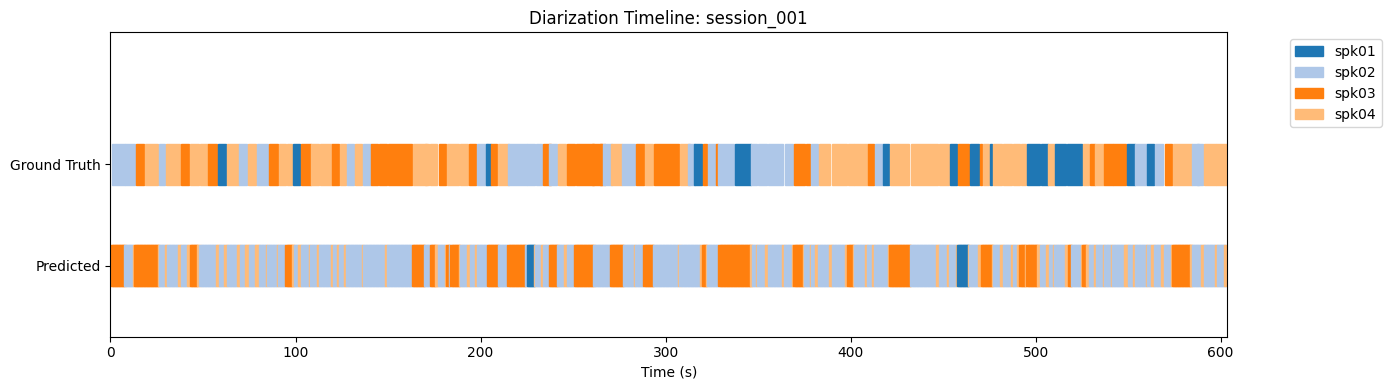

In [ ]:
# Example: visualize session_001 from sessions_smooth
base_dir = "/content/drive/MyDrive/problem_statement_6/sessions_smooth"
out_dir = "/content/drive/MyDrive/problem_statement_6/outputs/sd/sessions_smooth"

viz = TimelineVisualizer(base_dir, out_dir)
viz.plot_timeline("session_001", save_path="/content/session_001_timeline.png")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_diarization_per_speaker(gt_segments, pred_segments, session_id="session", time_range=None):
    """
    gt_segments / pred_segments: list of tuples (start, end, speaker)
    time_range: (start, end) in seconds to zoom in, or None for full length
    """

    # Collect unique speakers across GT + Pred
    gt_speakers = sorted(set(seg[2] for seg in gt_segments))
    pred_speakers = sorted(set(seg[2] for seg in pred_segments))
    all_speakers = sorted(set(gt_speakers) | set(pred_speakers))

    # Assign consistent colors
    cmap = plt.get_cmap("tab10")
    spk2color = {spk: cmap(i % 10) for i, spk in enumerate(all_speakers)}

    # Set up figure
    fig, ax = plt.subplots(figsize=(16, 6))

    ytick_labels, yticks = [], []
    ybase = 0

    def plot_segments(segments, label_prefix, ybase):
        for (s, e, spk) in segments:
            if time_range:
                s, e = max(s, time_range[0]), min(e, time_range[1])
                if s >= e:  # fully outside zoom window
                    continue
            ax.barh(ybase, e - s, left=s, height=0.4,
                    color=spk2color[spk], edgecolor="black")
        return ybase

    # Plot GT speakers
    for spk in gt_speakers:
        segs = [(s, e, spk) for (s, e, lab) in gt_segments if lab == spk]
        ytick_labels.append(f"GT-{spk}")
        plot_segments(segs, "GT", ybase)
        yticks.append(ybase)
        ybase += 1

    # Gap
    ybase += 0.5

    # Plot Pred speakers
    for spk in pred_speakers:
        segs = [(s, e, spk) for (s, e, lab) in pred_segments if lab == spk]
        ytick_labels.append(f"Pred-{spk}")
        plot_segments(segs, "Pred", ybase)
        yticks.append(ybase)
        ybase += 1

    # Axis formatting
    ax.set_yticks(yticks)
    ax.set_yticklabels(ytick_labels)
    ax.set_xlabel("Time (s)")
    ax.set_title(f"Diarization Timeline (Per Speaker): {session_id}")

    if time_range:
        ax.set_xlim(time_range)

    # Legend
    patches = [mpatches.Patch(color=clr, label=spk) for spk, clr in spk2color.items()]
    ax.legend(handles=patches, bbox_to_anchor=(1.01, 1), loc="upper left")

    plt.tight_layout()
    plt.show()


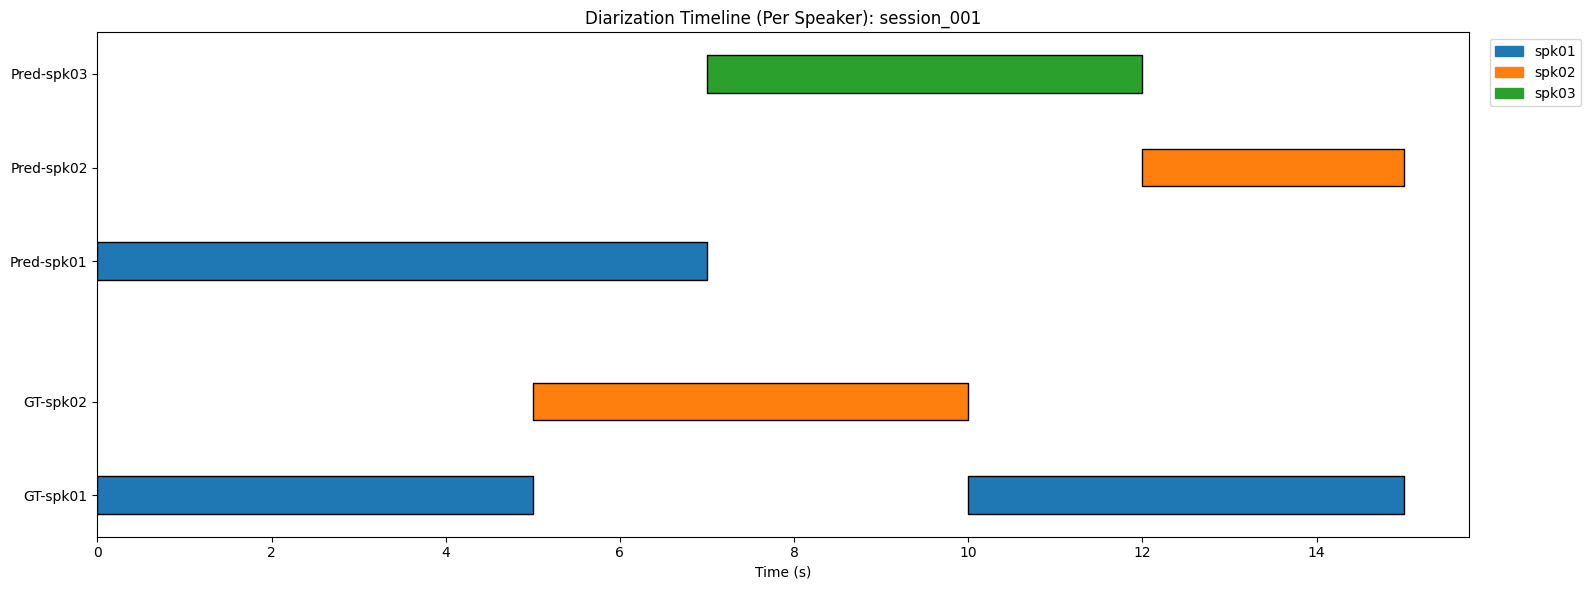

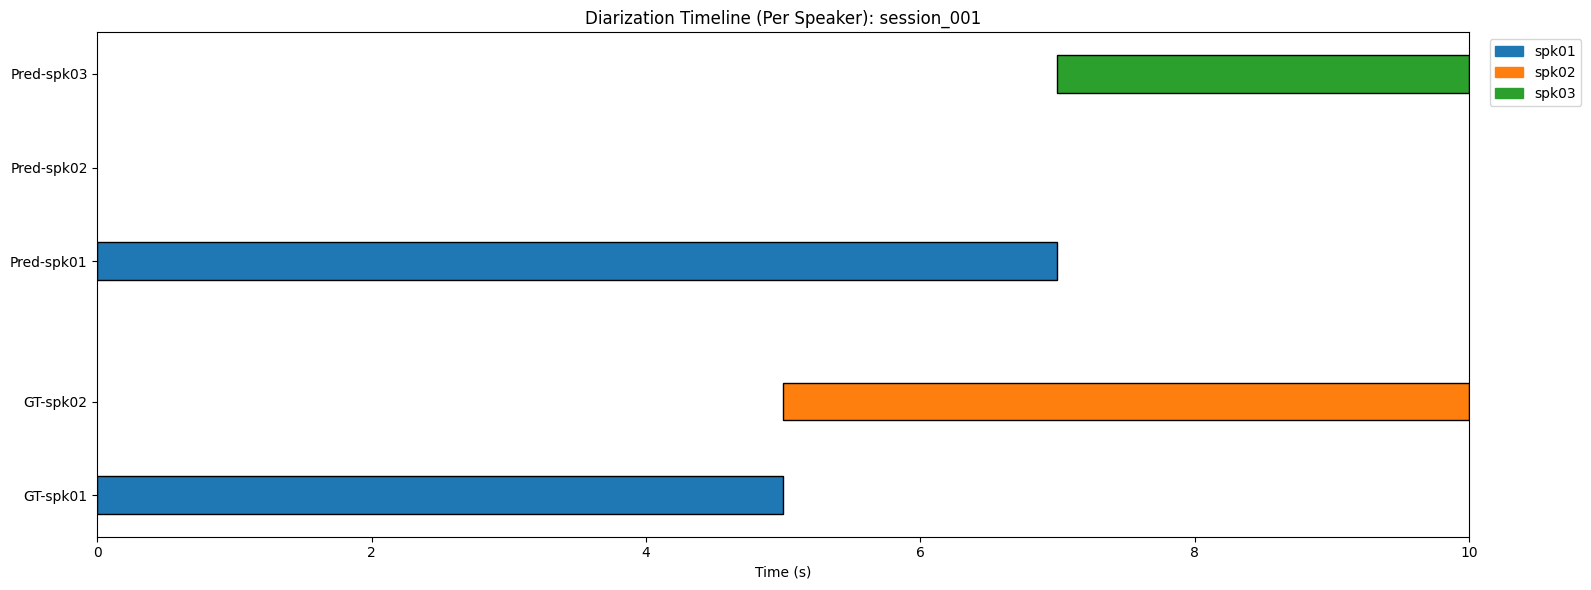

In [ ]:
# Example segments
gt_segments = [(0, 5, "spk01"), (5, 10, "spk02"), (10, 15, "spk01")]
pred_segments = [(0, 7, "spk01"), (7, 12, "spk03"), (12, 15, "spk02")]

# Full view
plot_diarization_per_speaker(gt_segments, pred_segments, session_id="session_001")

# Zoomed (0–10s)
plot_diarization_per_speaker(gt_segments, pred_segments, session_id="session_001", time_range=(0,10))


In [ ]:
# === PS-06-compliant DER evaluator ===
# - Ground truth: session_XXX.jsonl with {"start_ts","end_ts","speaker"} rows
# - System SD:     SD_session_XXX.csv  with start_ts,end_ts,speaker  (no conf used)
# - Output: a pandas DataFrame with per-session FA/Miss/Confusion & DER, plus an average row


import os, json
import numpy as np
import pandas as pd

# ------------------ helpers ------------------
def merge_intervals(ivls, max_gap=0.0):
    """Merge intervals; if max_gap>0, also bridge gaps up to that size."""
    if not ivls: return []
    ivls = sorted(ivls)
    out = []
    cs, ce = ivls[0]
    for s, e in ivls[1:]:
        if s <= ce + max_gap:  # join if overlapping or close within max_gap
            ce = max(ce, e)
        else:
            out.append((cs, ce))
            cs, ce = s, e
    out.append((cs, ce))
    return out

def length(ivls):
    return float(sum(e - s for s, e in ivls))

def intersect(a, b):
    """Intersection length between two interval sets."""
    i = j = 0; total = 0.0
    while i < len(a) and j < len(b):
        s1, e1 = a[i]; s2, e2 = b[j]
        s = max(s1, s2); e = min(e1, e2)
        if e > s: total += (e - s)
        if e1 <= e2: i += 1
        else: j += 1
    return total

def minus(a, b):
    """A \ B (returns intervals of a not covered by b)."""
    res = []
    for s1, e1 in a:
        cur = [(s1, e1)]
        for s2, e2 in b:
            nxt = []
            for s, e in cur:
                if e <= s2 or e2 <= s:  # no overlap
                    nxt.append((s, e))
                else:
                    if s < s2: nxt.append((s, s2))
                    if e2 < e: nxt.append((e2, e))
            cur = nxt
            if not cur: break
        res.extend(cur)
    return res

def load_gt_jsonl(jsonl_path, pause_merge=0.5):
    """Load GT segments per speaker; merge each speaker’s consecutive chunks separated by ≤ pause_merge."""
    by_spk = {}
    with open(jsonl_path, "r", encoding="utf-8") as f:
        for line in f:
            if not line.strip(): continue
            r = json.loads(line)
            s, e = float(r["start_ts"]), float(r["end_ts"])
            spk = str(r.get("speaker","")).strip()
            if e > s and spk:
                by_spk.setdefault(spk, []).append((s, e))
    # merge per speaker with ≤500 ms bridge (PS-06 rule)
    by_spk = {k: merge_intervals(v, max_gap=pause_merge) for k, v in by_spk.items()}
    # overall reference speech = union over all speakers
    all_ivls = sorted([iv for v in by_spk.values() for iv in v])
    ref_union = merge_intervals(all_ivls, max_gap=0.0)
    return by_spk, ref_union

def load_sys_csv(csv_path):
    """Load system segments per predicted speaker; merge (no pause rule for sys)."""
    try:
        df = pd.read_csv(csv_path)
        # Accept either our 3-col or PS-06 5-col; we ignore confidence & filename here
        cols = [c.lower() for c in df.columns]
        # normalize column names
        rename = {}
        for c in df.columns:
            lc = c.lower()
            if lc in ("start_ts","start","startsec"): rename[c] = "start_ts"
            elif lc in ("end_ts","end","endsec"):     rename[c] = "end_ts"
            elif lc in ("speaker","spk"):             rename[c] = "speaker"
            elif lc in ("audio file name","audio_file_name","file"): rename[c] = "audio"
        df = df.rename(columns=rename)
        df = df[["start_ts","end_ts","speaker"]].copy()
    except Exception:
        # fall back to simple CSV without header: start,end,speaker
        df = pd.read_csv(csv_path, header=None, names=["start_ts","end_ts","speaker"])
    df = df.dropna()
    by_spk = {}
    for _, r in df.iterrows():
        s, e = float(r["start_ts"]), float(r["end_ts"])
        spk = str(r["speaker"]).strip()
        if e > s and spk:
            by_spk.setdefault(spk, []).append((s, e))
    by_spk = {k: merge_intervals(v, max_gap=0.0) for k, v in by_spk.items()}
    sys_union = merge_intervals(sorted([iv for v in by_spk.values() for iv in v]), max_gap=0.0)
    return by_spk, sys_union

def compute_der_session(gt_jsonl, sys_csv, pause_merge=0.5):
    gt_by_spk, ref_union = load_gt_jsonl(gt_jsonl, pause_merge=pause_merge)
    sys_by_spk, hyp_union = load_sys_csv(sys_csv)
    ref_dur = length(ref_union)

    # False Alarm: hyp speech not in reference
    fa_ivls = minus(hyp_union, ref_union)
    fa = length(fa_ivls)

    # Missed Speech: reference not covered by any hyp
    miss_ivls = minus(ref_union, hyp_union)
    miss = length(miss_ivls)

    # Speaker Error: within ref ∩ hyp, time assigned to wrong speaker
    # For each GT speaker region, subtract intersections with the *same* predicted speaker;
    # anything remaining inside hyp coverage is a speaker confusion.
    wrong = 0.0
    rh = merge_intervals(sorted([iv for iv in ref_union if iv]), max_gap=0.0)
    ov_ref_hyp = intersect  # just a name alias

    # Build a global "correct" coverage as union over GT speakers intersect same predicted speaker
    correct_ivls_all = []
    for gt_spk, gt_ivls in gt_by_spk.items():
        # intersection with any hyp segments labeled gt_spk
        hyp_ivls_same = sys_by_spk.get(gt_spk, [])
        if not hyp_ivls_same: continue
        # compute pairwise intersections and collect
        for s1, e1 in gt_ivls:
            for s2, e2 in hyp_ivls_same:
                s = max(s1, s2); e = min(e1, e2)
                if e > s: correct_ivls_all.append((s, e))
    correct_ivls_all = merge_intervals(sorted(correct_ivls_all), max_gap=0.0)

    # total overlapped (ref ∩ hyp)
    # We need the *duration* of union(ref ∩ hyp) for confusion calc
    # That's: length( (ref ∩ hyp_union) )
    # Construct explicit intersection set:
    ref_hyp_intersections = []
    for s1, e1 in ref_union:
        for s2, e2 in hyp_union:
            s = max(s1, s2); e = min(e1, e2)
            if e > s: ref_hyp_intersections.append((s, e))
    ref_hyp_intersections = merge_intervals(sorted(ref_hyp_intersections), max_gap=0.0)
    overlapped = length(ref_hyp_intersections)

    # Confusion = overlapped - correctly assigned
    correct = length(correct_ivls_all)
    confusion = max(0.0, overlapped - correct)

    der = 0.0 if ref_dur == 0 else 100.0 * (fa + miss + confusion) / ref_dur
    return {
        "DER": der,
        "miss": miss,
        "fa": fa,
        "conf": confusion,
        "total_gt": ref_dur,
    }

# ------------------ batch runner ------------------
def evaluate_folder(gt_dir, sys_dir, prefix="SD_", pause_merge=0.5):
    rows = []
    for name in sorted(os.listdir(gt_dir)):
        if not name.endswith(".jsonl"): continue
        base = name[:-6]           # session_XXX
        gt_path  = os.path.join(gt_dir, name)
        sys_path = os.path.join(sys_dir, f"{prefix}{base}.csv")
        if not os.path.exists(sys_path):
            print(f"⚠️ missing system file for {base}")
            continue
        m = compute_der_session(gt_path, sys_path, pause_merge=pause_merge)
        m["session"] = base
        rows.append(m)
    df = pd.DataFrame(rows, columns=["DER","miss","fa","conf","total_gt","session"])
    if not df.empty:
        avg = df[["DER","miss","fa","conf","total_gt"]].mean().to_dict()
        avg["session"] = "AVERAGE"
        df = pd.concat([df, pd.DataFrame([avg])], ignore_index=True)
    return df

# ------------------ how to run (edit these) ------------------
BASE = "/content/drive/MyDrive/problem_statement_6"
GT_DIRS = {
    "smooth":   f"{BASE}/sessions_smooth",
    "balanced": f"{BASE}/sessions_balanced",
    "highov":   f"{BASE}/sessions_high_overlap",
    "codesw":   f"{BASE}/sessions_codeswitch",
}
SYS_DIRS = {
    "smooth":   f"{BASE}/outputs/sd/sessions_smooth",
    "balanced": f"{BASE}/outputs/sd/sessions_balanced",
    "highov":   f"{BASE}/outputs/sd/sessions_high_overlap",
    "codesw":   f"{BASE}/outputs/sd/sessions_codeswitch",
}

# Example: evaluate one scenario (set pause_merge=0.5s per PS-06)
df_smooth = evaluate_folder(GT_DIRS["smooth"], SYS_DIRS["smooth"], prefix="SD_", pause_merge=0.5)
print(df_smooth.round({"DER":3}))

# You can run the same for others:
# df_bal = evaluate_folder(GT_DIRS["balanced"], SYS_DIRS["balanced"])
# df_high = evaluate_folder(GT_DIRS["highov"],  SYS_DIRS["highov"])
# df_code = evaluate_folder(GT_DIRS["codesw"],  SYS_DIRS["codesw"])


<>:43: SyntaxWarning: invalid escape sequence '\ '
<>:43: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-1605078813.py:43: SyntaxWarning: invalid escape sequence '\ '
  """A \ B (returns intervals of a not covered by b)."""


       DER  miss        fa      conf   total_gt      session
0   76.606   0.0  43.10800  386.1420  560.33700  session_001
1   59.538   0.0  48.68600  280.2550  552.49100  session_002
2   70.392   0.0  45.21600  344.9780  554.31500  session_003
3   73.929   0.0  42.59600  371.7820  560.50700  session_004
4   66.123   0.0  39.38600  335.6500  567.18100  session_005
5   61.913   0.0  49.03000  291.8610  550.59800  session_006
6   74.524   0.0  53.03900  358.6590  552.43600  session_007
7   75.120   0.0  41.96700  380.7650  562.74100  session_008
8   83.531   0.0  47.74600  413.7030  552.42800  session_009
9   81.304   0.0  47.93900  402.1110  553.53700  session_010
10  70.214   0.0  41.49900  353.7700  562.94600  session_011
11  75.286   0.0  40.67500  382.8720  562.58100  session_012
12  65.414   0.0  49.44600  312.1340  552.75500  session_013
13  77.704   0.0  51.47600  374.6820  548.43700  session_014
14  72.040   0.0  44.01500  356.0650  555.36100  session_015
15  66.798   0.0  40.978

In [ ]:
import os, json
import numpy as np
import soundfile as sf
import librosa
from tqdm import tqdm
import torch
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, KMeans
from speechbrain.pretrained import EncoderClassifier


class Diarizer:
    def __init__(self, base_dir, scenario, out_subdir="outputs/sd",
                 win_sec=1.5, hop_sec=0.75, min_region_sec=0.5, batch_size=16,
                 clustering="agglomerative"):
        """
        base_dir: root of problem_statement_6
        scenario: e.g. 'sessions_smooth'
        clustering: 'agglomerative' | 'spectral' | 'kmeans'
        """
        self.base_dir = base_dir
        self.scenario = scenario
        self.in_dir = os.path.join(base_dir, scenario)
        self.out_dir = os.path.join(base_dir, out_subdir, scenario)
        os.makedirs(self.out_dir, exist_ok=True)

        self.SR = 16000
        self.WIN_SEC = win_sec
        self.HOP_SEC = hop_sec
        self.MIN_REGION_SEC = min_region_sec
        self.BATCH_SIZE = batch_size
        self.clustering = clustering

        # GPU setup
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Pretrained embedder
        self.encoder = EncoderClassifier.from_hparams(
            source="speechbrain/spkrec-ecapa-voxceleb",
            run_opts={"device": str(self.device)}
        )

    # ----------------- Core Helpers -----------------

    def frame_audio(self, x, sr):
        win = int(round(self.WIN_SEC * sr))
        hop = int(round(self.HOP_SEC * sr))
        frames, starts = [], []
        for s in range(0, len(x) - win + 1, hop):
            e = s + win
            frames.append(x[s:e])
            starts.append(s / sr)
        if len(x) % hop != 0:  # tail frame if long enough
            s = len(x) - win
            if s > 0 and (len(x) - s) / sr >= 0.5 * self.WIN_SEC:
                frames.append(x[s:])
                starts.append(max(0, s) / sr)
        return frames, np.array(starts, dtype=np.float32)

    def embed_frames(self, frames):
        """Batch pad frames and compute ECAPA embeddings on GPU."""
        if not frames:
            return np.zeros((0, 192), dtype=np.float32)

        embs_list = []
        for i in range(0, len(frames), self.BATCH_SIZE):
            chunk = frames[i:i+self.BATCH_SIZE]
            maxlen = max(len(f) for f in chunk)
            pad_np = np.stack(
                [np.pad(f.astype(np.float32), (0, maxlen - len(f))) for f in chunk],
                axis=0
            )
            wavs = torch.from_numpy(pad_np).to(self.device)
            with torch.no_grad():
                emb = self.encoder.encode_batch(wavs)  # [B, 1, D]
            embs_list.append(emb.squeeze(1).cpu().numpy())
        return np.vstack(embs_list)

    def cluster_embeddings(self, embs, n_spk):
        if len(embs) == 0:
            return np.array([], dtype=int)

        if self.clustering == "agglomerative":
            clust = AgglomerativeClustering(
                n_clusters=n_spk, metric='cosine', linkage='average'
            )
            labels = clust.fit_predict(embs)

        elif self.clustering == "spectral":
            # cosine similarity → affinity matrix
            norm_embs = embs / (np.linalg.norm(embs, axis=1, keepdims=True) + 1e-10)
            aff = np.dot(norm_embs, norm_embs.T)
            clust = SpectralClustering(
                n_clusters=n_spk,
                affinity="precomputed",
                assign_labels="kmeans",
                random_state=42
            )
            labels = clust.fit_predict(aff)

        elif self.clustering == "kmeans":
            clust = KMeans(n_clusters=n_spk, random_state=42, n_init=10)
            labels = clust.fit_predict(embs)

        else:
            raise ValueError(f"Unknown clustering method: {self.clustering}")

        return labels

    def labels_to_regions(self, starts, labels):
        """Merge consecutive frames into regions per speaker label."""
        if len(labels) == 0:
            return []
        regions = []
        cur_lab, cur_start, cur_end = labels[0], float(starts[0]), float(starts[0]) + self.WIN_SEC
        for i in range(1, len(labels)):
            s, e = float(starts[i]), float(starts[i]) + self.WIN_SEC
            if labels[i] == cur_lab and abs(s - cur_end) <= 1e-6:
                cur_end = e
            else:
                if cur_end - cur_start >= self.MIN_REGION_SEC:
                    regions.append((cur_start, cur_end, int(cur_lab)))
                cur_lab, cur_start, cur_end = labels[i], s, e
        if cur_end - cur_start >= self.MIN_REGION_SEC:
            regions.append((cur_start, cur_end, int(cur_lab)))
        return regions

    def map_clusters(self, labels):
        uniq = np.unique(labels)
        mapping = {lab: f"spk{idx+1:02d}" for idx, lab in enumerate(sorted(uniq))}
        return np.vectorize(mapping.get)(labels), mapping

    def read_oracle_n_speakers(self, jsonl_path):
        spk = set()
        with open(jsonl_path, "r", encoding="utf-8") as f:
            for line in f:
                if not line.strip():
                    continue
                rec = json.loads(line)
                if rec.get("speaker"):
                    spk.add(rec["speaker"])
        return max(1, len(spk))

    # ----------------- Main Run -----------------

    def diarize_all(self):
        jsonl_files = sorted([f for f in os.listdir(self.in_dir) if f.endswith(".jsonl")])
        assert jsonl_files, f"No .jsonl found in {self.in_dir}"

        for jname in tqdm(jsonl_files, desc=f"Diarizing {self.scenario}"):
            base = jname[:-6]
            wav_path = os.path.join(self.in_dir, base + ".wav")
            jpath = os.path.join(self.in_dir, jname)
            out_csv = os.path.join(self.out_dir, f"SD_{base}.csv")

            if not os.path.exists(wav_path):
                print(f" ! missing wav for {jname}, skipping")
                continue

            x, sr = sf.read(wav_path, always_2d=False)
            if sr != self.SR:
                x = librosa.resample(x.astype(np.float32), orig_sr=sr, target_sr=self.SR)
                sr = self.SR
            if x.ndim == 2:
                x = x.mean(axis=1)

            frames, starts = self.frame_audio(x, sr)
            embs = self.embed_frames(frames)
            K = self.read_oracle_n_speakers(jpath)
            clabels = self.cluster_embeddings(embs, K)
            regions = self.labels_to_regions(starts, clabels)
            _, mapping = self.map_clusters(clabels if len(clabels) else np.array([0]))

            with open(out_csv, "w", encoding="utf-8") as f:
                f.write("start_ts,end_ts,speaker\n")
                for (s, e, lab) in regions:
                    f.write(f"{s:.3f},{e:.3f},{mapping.get(lab, f'spk{lab+1:02d}')}\n")

            print(f"Wrote {os.path.basename(out_csv)} (regions: {len(regions)}, K={K})")

        print(f"\n✅ Done. CSVs in {self.out_dir}")


In [ ]:
BASE = "/content/drive/MyDrive/problem_statement_6"

# Agglomerative (default)
d1 = Diarizer(BASE, "sessions_smooth", clustering="agglomerative")
d1.diarize_all()

# Spectral
d2 = Diarizer(BASE, "sessions_smooth", clustering="spectral")
d2.diarize_all()

# KMeans
d3 = Diarizer(BASE, "sessions_smooth", clustering="kmeans")
d3.diarize_all()


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


hyperparams.yaml: 0.00B [00:00, ?B/s]

INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
/usr/local/lib/python3.12/dist-packages/speechbrain/utils/torch_audio_backend.py:57: UserWarning: torchaudio._backend.list_audio_backends has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  available_backends = torchaudio.list_audio_backends()
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _load
DEBUG:speechbrain.utils.checkpoints:Registered parameter transfer hook for _load
/usr/local/lib/python3.12/dist-packages/speechbrain/utils/autocast.py:188: Fut

embedding_model.ckpt:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


mean_var_norm_emb.ckpt:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


classifier.ckpt:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/classifier.ckpt
INFO:speechbrain.utils.fetching:Fetch label_encoder.txt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


label_encoder.txt: 0.00B [00:00, ?B/s]

DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["label_encoder"] = /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/label_encoder.txt
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: embedding_model, mean_var_norm_emb, classifier, label_encoder
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): embedding_model -> /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/embedding_model.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): mean_var_norm_emb -> /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/mean_var_norm_emb.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): classifier -> /root/.cache/huggingface/hub/models--speechb

KeyboardInterrupt: 